In [5]:
!pip install torch torchvision matplotlib pillow

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch 
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

print("All libraries are successfully imported")

All libraries are successfully imported


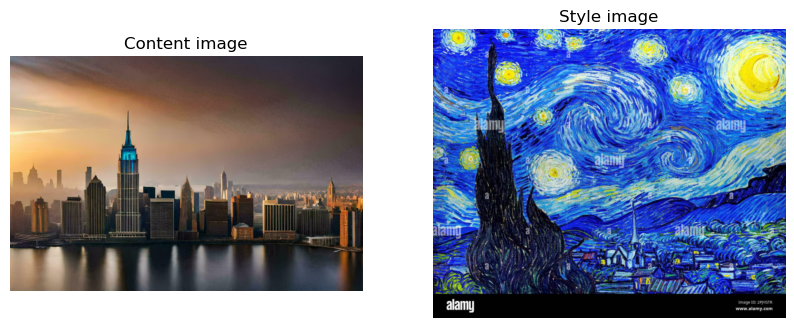

In [4]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image , UnidentifiedImageError

def load_image(path,max_size=512):
    if not os.path.isfile(path):
        raise FileNotFoundError(f" File not found:{path}")
        
    if not path.lower().endswith((".jpg",".jpeg",".png")):
        raise ValueError("Invalid file format . Please use .jpg,.jpeg or.png images only")

    try:
        image = Image.open(path).convert('RGB')
    except UnidentifiedImageError:
        raise UnidentifiedImageError(
            f"Cannot identify image file: {path}\n"
            "Make sure the file is a real image and not just renamed to .jpg"
    )
    size = min(max(image.size),max_size)
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)

content_img = load_image("content.jpg")
style_img = load_image("style.jpg")

def imshow(tensor,title):
    image = tensor.clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
imshow(content_img,"Content image")
plt.subplot(1,2,2)
imshow(style_img,"Style image")
plt.show()


In [5]:
import torchvision.models as models
import torch.nn as nn
import torch

vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)

print("VGG19 model loaded and moved to ", device)


C:\Users\Mohamed Fatheen\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mohamed Fatheen\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG19 model loaded and moved to  cpu


In [6]:
content_layers = ['conv4_2']
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']

class VGGFeatures(nn.Module):
    def __init__(self,vgg,content_layers,style_layers):
        super(VGGFeatures, self).__init__()
        self.vgg = vgg
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.model_layers = {}
        self.layer_map = {
            '0':'conv1_1','5':'conv2_1',
            '10':'conv3_1','19':'conv4_1',
            '21':'conv4_2','28':'conv5_1'
        }

    def forward(self,x):
        content_features = {}
        style_features = {}
        for name,layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.layer_map:
                layer_name = self.layer_map[name]
                if layer_name in self.content_layers:
                    content_features[layer_name] = x
                if layer_name in self.style_layers:
                    style_features[layer_name] = x 
        return content_features, style_features

feature_extractor = VGGFeatures(vgg,content_layers,style_layers).to(device)

In [10]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h*w)
    G = torch.mm(features, features.t())
    return G/(c*h*w)

In [11]:
content_img = content_img.to(device)
style_img = style_img.to(device)

content_features,_ = feature_extractor(content_img)
_, style_features = feature_extractor(style_img)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

print("Features extracted and gram matrices are computed")

Features extracted and gram matrices are computed


In [12]:
generated = content_img.clone().requires_grad_(True).to(device)
optimizer = torch.optim.Adam([generated], lr=0.01)
content_weight = 1e3
style_weight = 1e4
steps = 750
for step in range(1,steps+1):
    gen_content,gen_style = feature_extractor(generated)
    content_loss = torch.mean((gen_content['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_grams:
        gen_feature = gen_style[layer]
        gen_gram = gram_matrix(gen_feature)
        target_gram = style_grams[layer]
        style_loss += torch.mean((gen_gram - target_gram)**2)

    total_loss = content_weight*content_loss+style_weight*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step%50 == 0:
        print(f"Step {step}/{steps}, Total loss:{total_loss.item():2f}")

Step 50/750, Total loss:9.034008
Step 100/750, Total loss:4.524614
Step 150/750, Total loss:3.459747
Step 200/750, Total loss:2.992619
Step 250/750, Total loss:2.613002
Step 300/750, Total loss:2.465093
Step 350/750, Total loss:2.330111
Step 400/750, Total loss:2.186060
Step 450/750, Total loss:2.169475
Step 500/750, Total loss:2.085193
Step 550/750, Total loss:2.056315
Step 600/750, Total loss:2.493915
Step 650/750, Total loss:2.483282
Step 700/750, Total loss:2.753339
Step 750/750, Total loss:1.699042


In [13]:
from torchvision.utils import save_image

save_image(generated.clone().detach(), "output.jpg")
print("Stylized output saved as output.jpg")

Stylized output saved as output.jpg
